In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from numpy.random import RandomState
from sklearn.dummy import DummyRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import cross_val_score,cross_validate,train_test_split
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

In [3]:
try:
    df_train=pd.read_csv(r"C:\Users\promero\Downloads\EJERCICIOS\DATASETS\gold_recovery_train.csv")
except:
    df_train=pd.read_csv(r"/datasets/gold_recovery_train.csv")
try:
    df_test=pd.read_csv(r"C:\Users\promero\Downloads\EJERCICIOS\DATASETS\gold_recovery_test.csv")
except:
    df_test=pd.read_csv(r"/datasets/gold_recovery_test.csv")
try:
    df_full=pd.read_csv(r"C:\Users\promero\Downloads\EJERCICIOS\DATASETS\gold_recovery_full.csv")
except:
    df_full=pd.read_csv(r"/datasets/gold_recovery_full.csv")


## Revisar los datos

In [4]:
print("full",df_full.shape)
print("train",df_train.shape)
print("test",df_test.shape)

full (22716, 87)
train (16860, 87)
test (5856, 53)


Con 87 columnas es muy dificil poder ver los detalles del Dataframe. A su vez podemos observar que el Dataframe de prueba tiene menos columnas que los otros por lo que procedere a buscar cuales quedaron fuera.

In [5]:
columns_train=df_train.columns
columns_test=df_test.columns
columns_rest=columns_train.drop(columns_test)

print(len(columns_rest))
columns_rest

34


Index(['final.output.concentrate_ag', 'final.output.concentrate_pb',
       'final.output.concentrate_sol', 'final.output.concentrate_au',
       'final.output.recovery', 'final.output.tail_ag', 'final.output.tail_pb',
       'final.output.tail_sol', 'final.output.tail_au',
       'primary_cleaner.output.concentrate_ag',
       'primary_cleaner.output.concentrate_pb',
       'primary_cleaner.output.concentrate_sol',
       'primary_cleaner.output.concentrate_au',
       'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_pb',
       'primary_cleaner.output.tail_sol', 'primary_cleaner.output.tail_au',
       'rougher.calculation.sulfate_to_au_concentrate',
       'rougher.calculation.floatbank10_sulfate_to_au_feed',
       'rougher.calculation.floatbank11_sulfate_to_au_feed',
       'rougher.calculation.au_pb_ratio', 'rougher.output.concentrate_ag',
       'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol',
       'rougher.output.concentrate_au', 'rougher.outpu

Podemos observar que las columnas que no aparecen son las de output que nuestro modelo tendrá que predecir.

In [6]:
#Numerador para el calculo
num=df_train["rougher.output.concentrate_au"]*(df_train["rougher.input.feed_au"]-df_train["rougher.output.tail_au"])
#Denominador
dem=df_train["rougher.input.feed_au"]*(df_train["rougher.output.concentrate_au"]-df_train["rougher.output.tail_au"])
#Calculamos el EAM entre nuestro calculo y los resultados
(df_train["rougher.output.recovery"]-num/dem*100).abs().mean()


9.303415616264301e-15

Con este EAN tan bajo podemos decir que los datos y resultados se encuentran correctos. Recordemos que al inicio nos especifica que algunos parámetros no esán disponibles porque se calcularon o midieron más tarde, el valor de EAN pued ser resultado de estos datos faltantes.

## Preprocesamiento de datos

In [7]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                22716 non-null  object 
 1   final.output.concentrate_ag                         22627 non-null  float64
 2   final.output.concentrate_pb                         22629 non-null  float64
 3   final.output.concentrate_sol                        22331 non-null  float64
 4   final.output.concentrate_au                         22630 non-null  float64
 5   final.output.recovery                               20753 non-null  float64
 6   final.output.tail_ag                                22633 non-null  float64
 7   final.output.tail_pb                                22516 non-null  float64
 8   final.output.tail_sol                               22445 non-null  float64


Podemos ver que todas las columnas cuentan con valores ausentes menos 2, primary_cleaner.input.feed_size y date.

In [8]:
df_full["primary_cleaner.input.feed_size"].describe()

count    22716.000000
mean         7.288872
std          0.617357
min          1.080000
25%          6.920000
50%          7.280000
75%          7.680000
max         15.500000
Name: primary_cleaner.input.feed_size, dtype: float64

Los valores de la media y mediana son casi iguales, revisare los datos de la columna output ya que sera de gran importancia para crear los modelos.

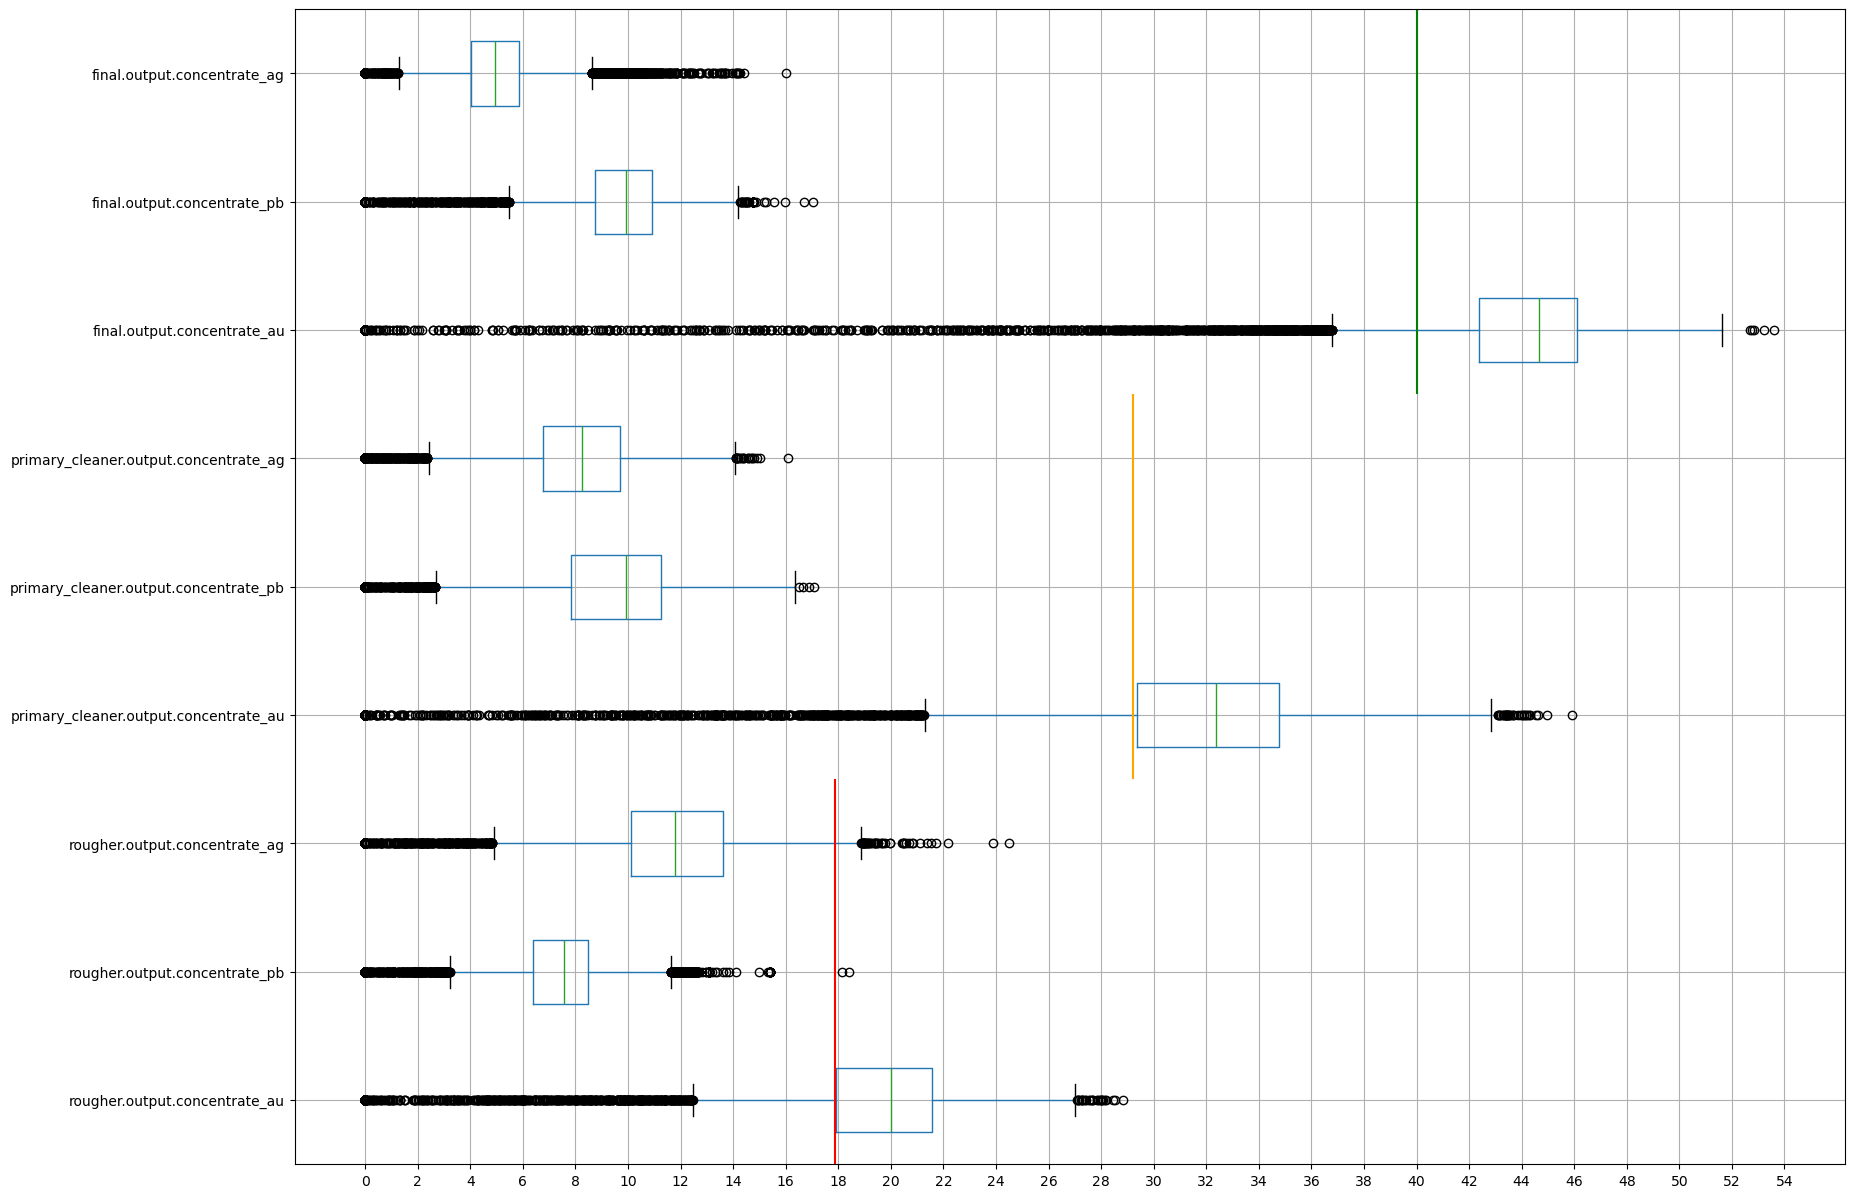

In [9]:
df_full.boxplot(["rougher.output.concentrate_au","rougher.output.concentrate_pb","rougher.output.concentrate_ag","primary_cleaner.output.concentrate_au","primary_cleaner.output.concentrate_pb","primary_cleaner.output.concentrate_ag",'final.output.concentrate_au', 'final.output.concentrate_pb', 'final.output.concentrate_ag'],figsize=(20,15),vert=False)
plt.xticks(np.arange(0,55,2.0))
#Promedio de rougher del oro en rojo
plt.vlines(df_full["rougher.output.concentrate_au"].mean(),ymin=0.5,ymax=3.5,colors="red")
#Promedio de purificación primaria del oro en naranja
plt.vlines(df_full["primary_cleaner.output.concentrate_au"].mean(),ymin=3.5,ymax=6.5,colors="orange")
#Promedio de la purificación secundaria del oro en verde
plt.vlines(df_full["final.output.concentrate_au"].mean(),ymin=6.5,ymax=9.5,colors="green")
plt.show()


Podemos observar un sesgo con muchos valores bajo la norma. Podríamos borrar los datos vacíos pero pienso que esto perjudicaría el Dataframe ya que son más del 10% de los datos. Tal vez sea buena idea llenar los datos vacíos con el comportamineto de los datos en el tiempo. Utilizare ffill para que cada dato se llene según el dato anterior en el tiempo.

In [11]:
df_train=df_train.ffill()
df_test=df_test.ffill()
df_full=df_full.ffill()

## Análisis de los datos

Se ejecutara los siguientes puntos en el análisis:

1. Observaremos como cambia la concentración de metales de acuerdo a la etapa de purificación. Tomando en cuenta que el proceso tiene 2 etapas de purificación, por lo que tendríamos que ver un aumento en la pureza de los productos. La cantidad de oro debería aumentar.
2. Se buscara hacer una comparación del tamaño de las particulas de la alimentación en el conjunto de entrenamiento y en el de prueba. Si estas distribuciones varían significativamente, la evaluación no será correcta.
3. Se buscara encontrar algún valor anormal en la distribución total y si vale la pena eliminarlo los valores.

## Concentración de metales en la purificación

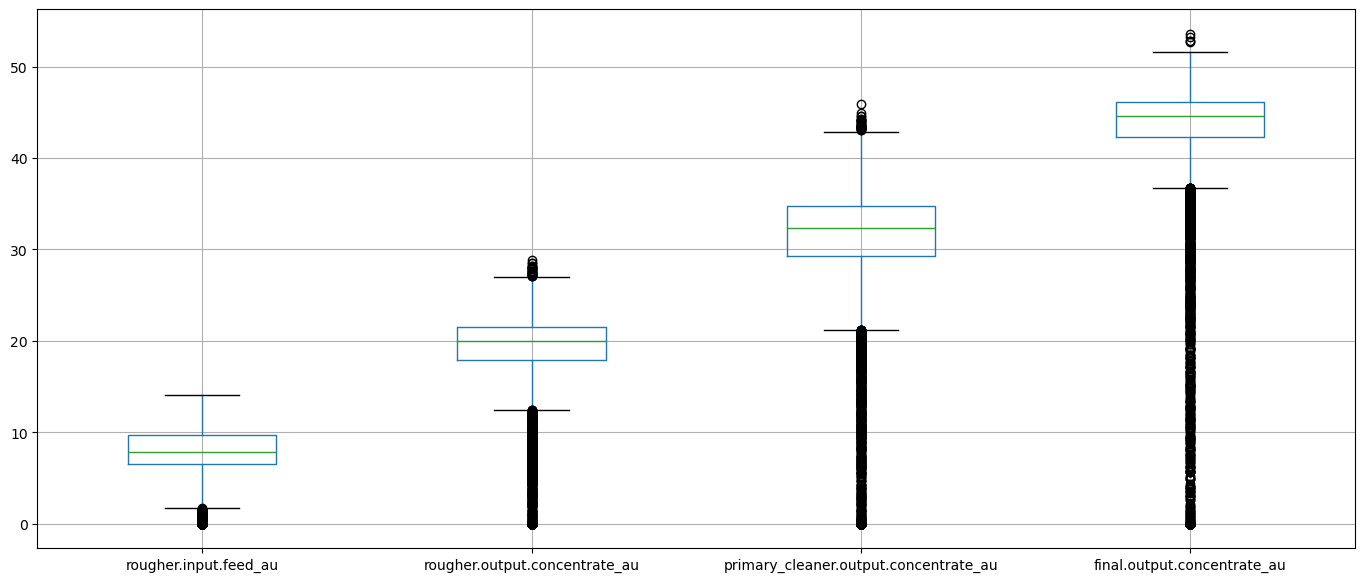

In [16]:
#Observaremos la concentración del Oro
df_full.boxplot(["rougher.input.feed_au","rougher.output.concentrate_au",'primary_cleaner.output.concentrate_au', 'final.output.concentrate_au'],figsize=(17,7))
plt.show()

Obsrvamos como en cada etapa las cantidades de oro aumentan, ya que el objetivo del proceso es obtener oro eso tiene mucho sentido.

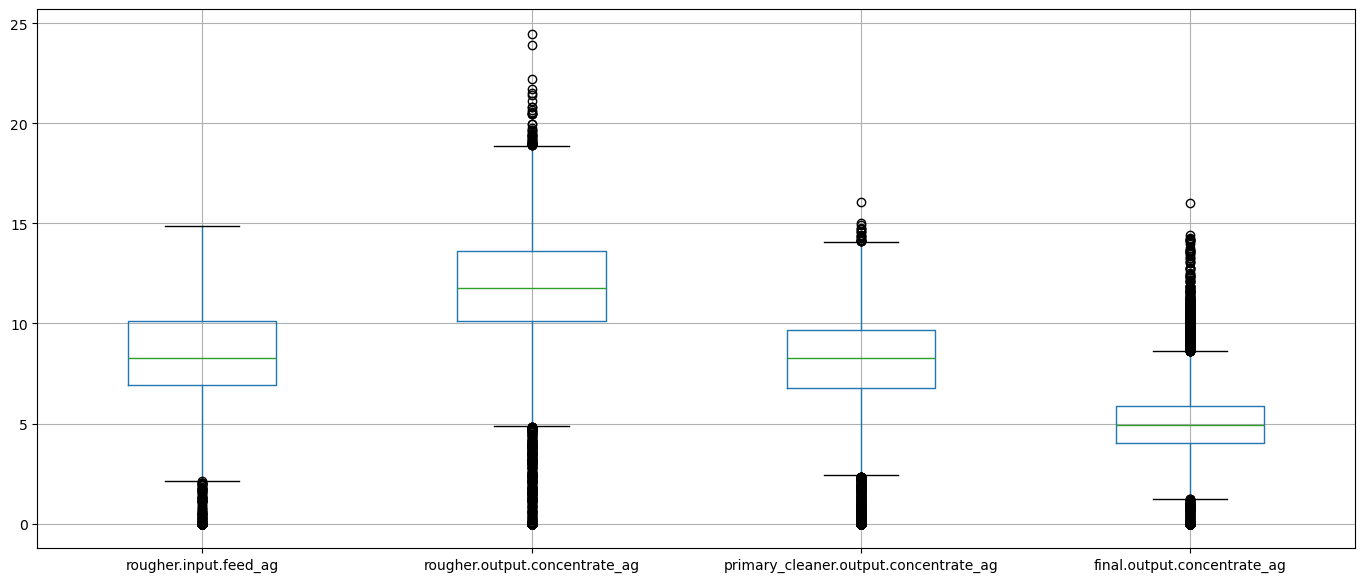

In [17]:
#Observaremos la concentración de Plata
df_full.boxplot(["rougher.input.feed_ag","rougher.output.concentrate_ag","primary_cleaner.output.concentrate_ag","final.output.concentrate_ag"],figsize=(17,7))
plt.show()

Podemos observar que cuando se tiene mayor concentrado de Plata es en la etapa de salida de rougher.

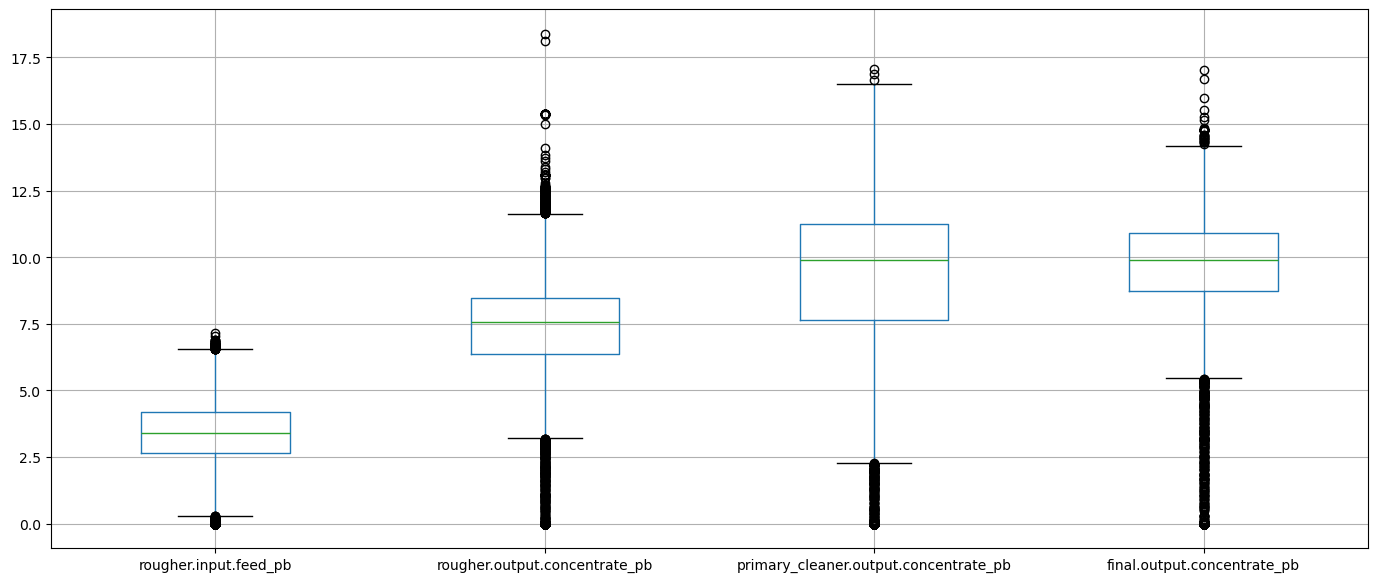

In [18]:
#Observaremos la concentración de Plomo
df_full.boxplot(["rougher.input.feed_pb","rougher.output.concentrate_pb","primary_cleaner.output.concentrate_pb","final.output.concentrate_pb"],figsize=(17,7))
plt.show()

El plomo, al igual que el oro, aumenta con el paso de las etapas del proceso excepto en la última filtración que parece estabilizarse.

## Distribuciones de alimentación

Comparare la distribución de tamaño de las particulas en df_train y df_test.


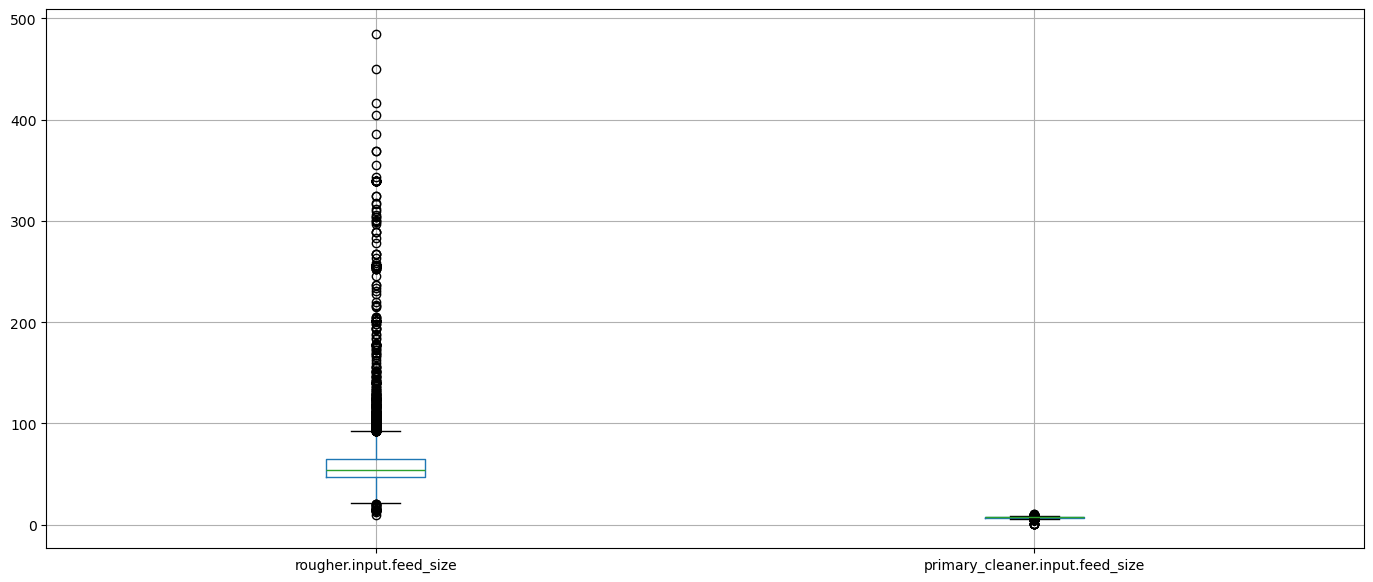

In [19]:
#Set de entrenamiento
df_train.boxplot(["rougher.input.feed_size","primary_cleaner.input.feed_size"],figsize=(17,7))
plt.show()

In [20]:
df_train["rougher.input.feed_size"].describe()

count    16860.000000
mean        60.188595
std         30.522242
min          9.659576
25%         47.548897
50%         54.066003
75%         65.397249
max        484.967466
Name: rougher.input.feed_size, dtype: float64

In [21]:
df_train["primary_cleaner.input.feed_size"].describe()

count    16860.000000
mean         7.297285
std          0.619166
min          1.080000
25%          6.940000
50%          7.285000
75%          7.700000
max         10.470000
Name: primary_cleaner.input.feed_size, dtype: float64

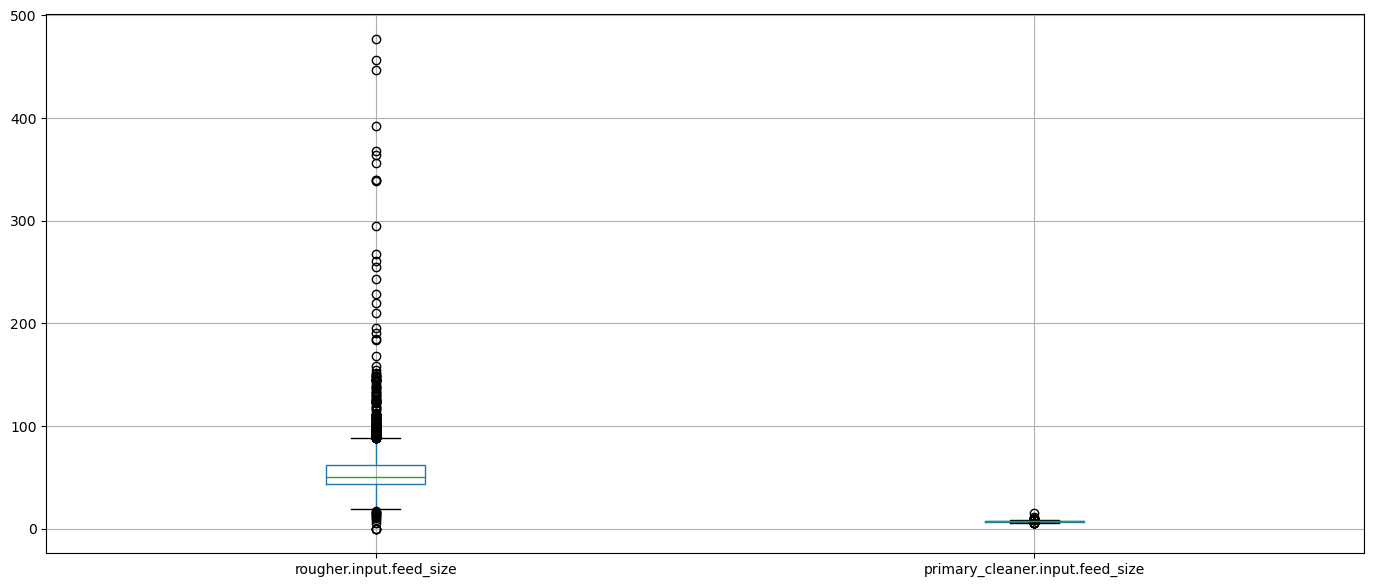

In [22]:
#Set de testeo
df_test.boxplot(["rougher.input.feed_size","primary_cleaner.input.feed_size"],figsize=(17,7))
plt.show()

In [23]:
df_test["rougher.input.feed_size"].describe()

count    5856.000000
mean       55.898866
std        22.707969
min         0.046369
25%        43.852884
50%        49.964796
75%        61.628003
max       477.445473
Name: rougher.input.feed_size, dtype: float64

In [24]:
df_test["primary_cleaner.input.feed_size"].describe()

count    5856.000000
mean        7.264651
std         0.611526
min         5.650000
25%         6.885625
50%         7.259333
75%         7.650000
max        15.500000
Name: primary_cleaner.input.feed_size, dtype: float64

## Comentarios

Podemos ver que las cantidades de entrada son mucho menores en la primera limpieza despues del proceso rougher. Creo que esto es algo normal ya que despues del primer proceso rougher se eliminan muchos otros metales que continiene en la primer extracción.

## Concentraciones totales en todas las etapas

En esta parte, el objetivo es resolver las siguientes preguntas:

1. Se observa algún valor anormal en la distribución total?
2. Si es así ¿Vale la pena eliminar estos valores de ambas muestras?



In [45]:

def up_iqr_finder (data,column):
    return data[column].quantile(0.75)+(data[column].quantile(0.75)-data[column].quantile(0.25))*1.5

#
def down_iqr_finder (data, column):
    return data[column].quantile(0.25) - (data[column].quantile(0.75) - data[column].quantile(0.25))*1.5


def iqr_limit (data,limit_up,limit_down,column):
    data_set=data[(data[column]<=limit_up)&(data[column]>=limit_down)]
    return data_set

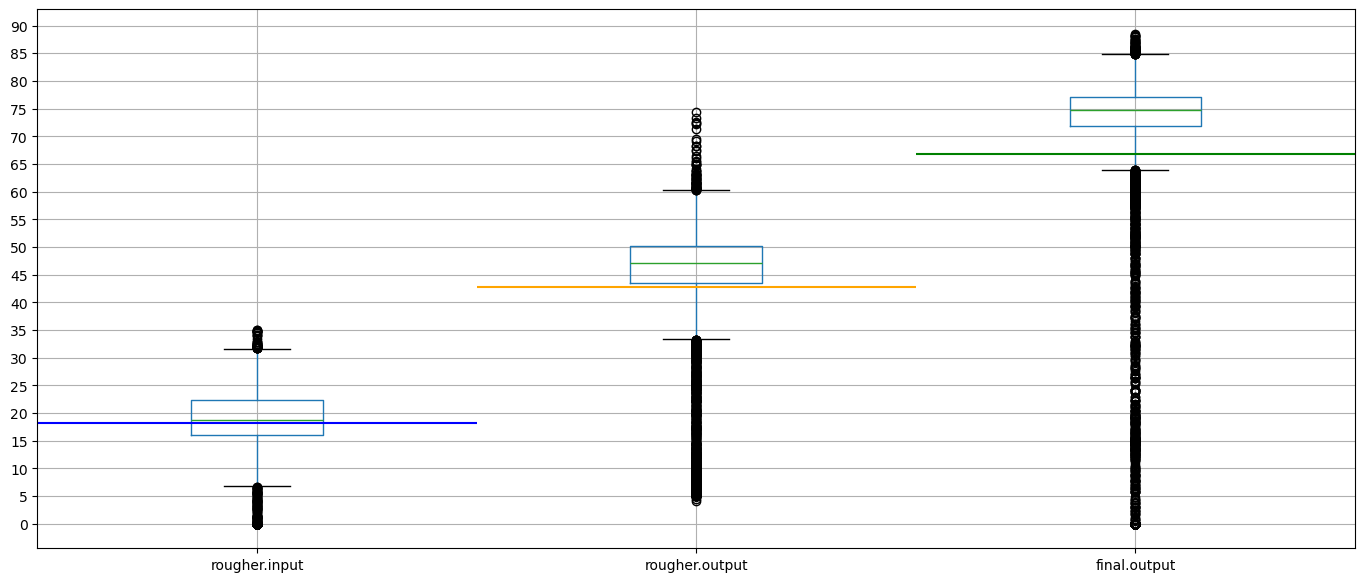

In [30]:
#Unimos las entradas del proceso rougher
df_train["rougher.input"]=df_train["rougher.input.feed_ag"]+df_train["rougher.input.feed_au"]+df_train["rougher.input.feed_pb"]
#Unimos las salidas del proceso rougher
df_train['rougher.output'] = df_train['rougher.output.concentrate_au']+df_train['rougher.output.concentrate_pb']+df_train['rougher.output.concentrate_ag']+df_train['rougher.output.tail_ag']+df_train['rougher.output.tail_au']+df_train['rougher.output.tail_pb']

#Unimos las salidas del proceso final
df_train['final.output'] = df_train['final.output.concentrate_au']+df_train['final.output.concentrate_ag']+df_train['final.output.concentrate_pb']+df_train['final.output.tail_au']+df_train['final.output.tail_ag']+df_train['final.output.tail_pb']


df_train.boxplot(["rougher.input","rougher.output","final.output"],figsize=(17,7))
plt.yticks(np.arange(0,91,5))
#Promedio de las entradas rougher en azul
plt.hlines(df_train["rougher.input"].mean(),xmin=.5,xmax=1.5,colors="blue")
#Promedio de las salida rougher en naranja
plt.hlines(df_train["rougher.output"].mean(),xmin=1.5,xmax=2.5,colors="orange")
#Promedio de las salidas del proceso final verde
plt.hlines(df_train["final.output"].mean(),xmin=2.5,xmax=3.5,colors="green")
plt.show()


Ahora revisaremos los mismos datos en un histograma, para esto conservare los mismo colores de la grfica anterior.

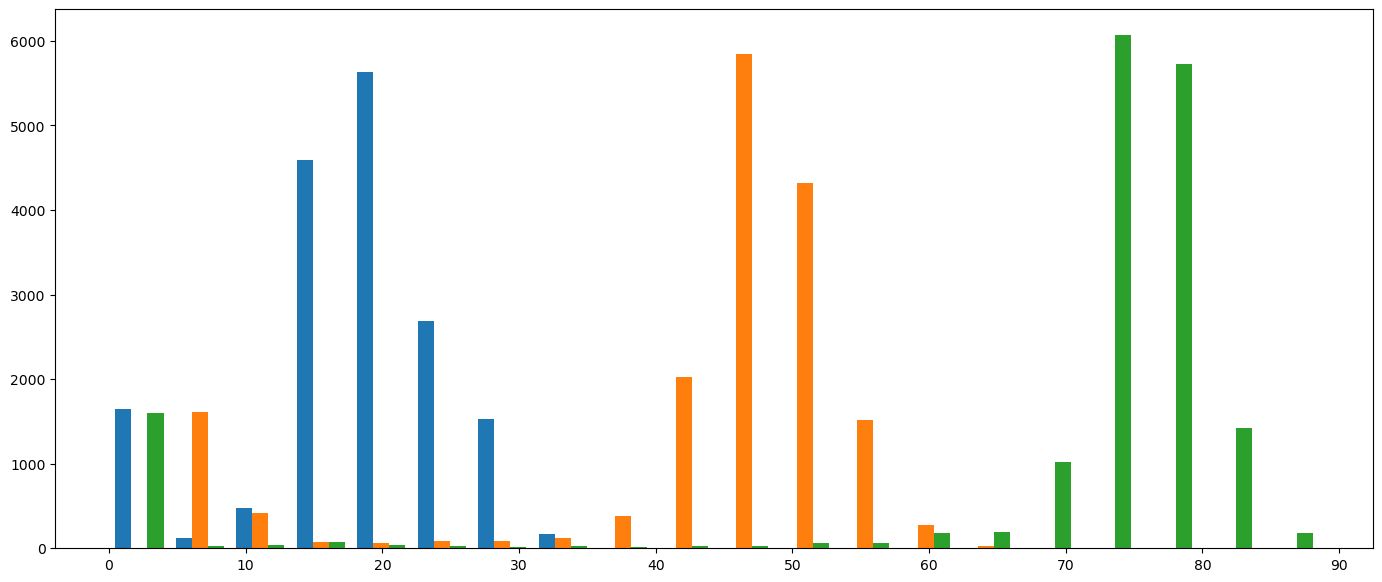

In [34]:
plt.figure(figsize=(17,7))
plt.hist([df_train["rougher.input"],df_train["rougher.output"],df_train["final.output"]],bins=20)
plt.xticks(np.arange(0,91,10))
plt.show()

Respondiendo a las preguntas anteriores determinamos lo siguiente:

1. Contamos con valores fuera de la norma. En todas las etapas podemos observar valores bastante dispersos e inclusive encontrar datos cercanos a 0 en cada una de las etapas.

2. Concluyo que si vale la pena eliminar los valores atipicos aunque represente una perdida grande de la información. Buscare concentrarme en final.output y ougher.output para eliminar los datos atipicos de las filas con base a estas columnas.

In [46]:
print("Largo original:",len(df_train))
#Procedo a fijar los limites de corte
rougher_up = up_iqr_finder(df_train, 'rougher.output')
rougher_down = down_iqr_finder(df_train, 'rougher.output')

final_up=up_iqr_finder(df_train,"final.output")
final_down=down_iqr_finder(df_train,"final.output")

#Procedo a limpiar los datos atipicos
df_train_clean=iqr_limit(df_train,rougher_up,rougher_down,"rougher.output")
df_train_clean=iqr_limit(df_train_clean,final_up,final_down,"final.output")

#Ahora procedere a revisar el largo despues de la limpieza
print("Largo post limpieza:",len(df_train_clean))

Largo original: 16860
Largo post limpieza: 13761


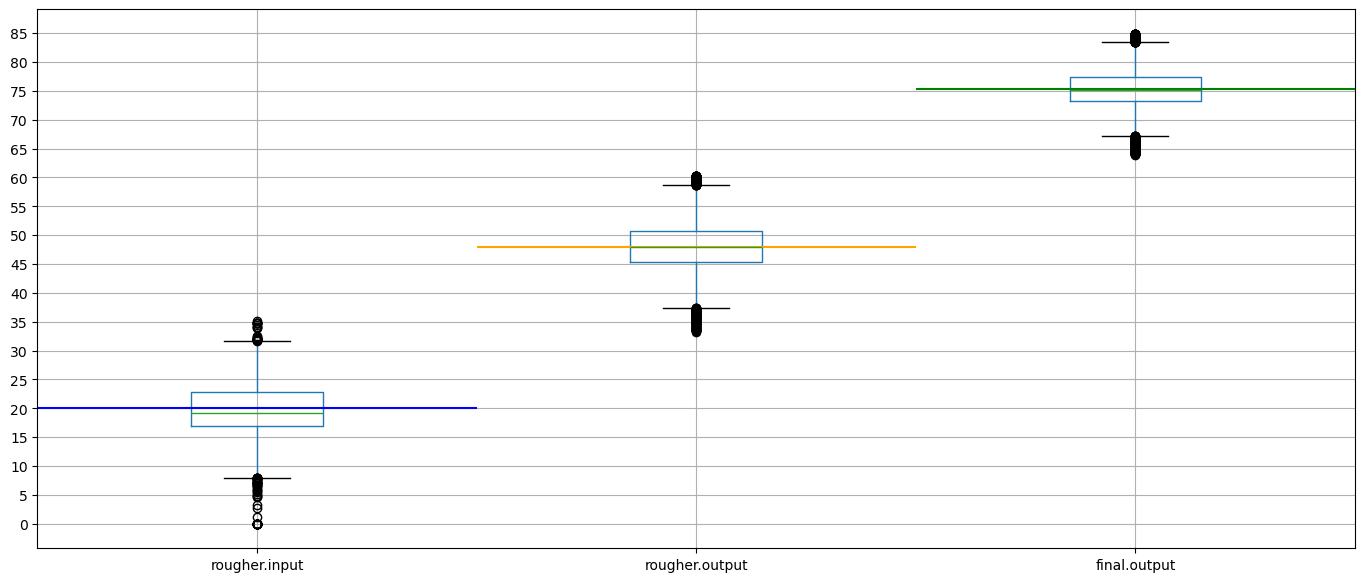

In [47]:
#Ahora volvemos a graficar para revisar los cmabios
df_train_clean.boxplot(["rougher.input","rougher.output","final.output"],figsize=(17,7))
plt.yticks(np.arange(0,91,5))
#Promedio de las entradas rougher en azul
plt.hlines(df_train_clean["rougher.input"].mean(),xmin=.5,xmax=1.5,colors="blue")
#Promedio de las salida rougher en naranja
plt.hlines(df_train_clean["rougher.output"].mean(),xmin=1.5,xmax=2.5,colors="orange")
#Promedio de las salidas del proceso final verde
plt.hlines(df_train_clean["final.output"].mean(),xmin=2.5,xmax=3.5,colors="green")
plt.show()


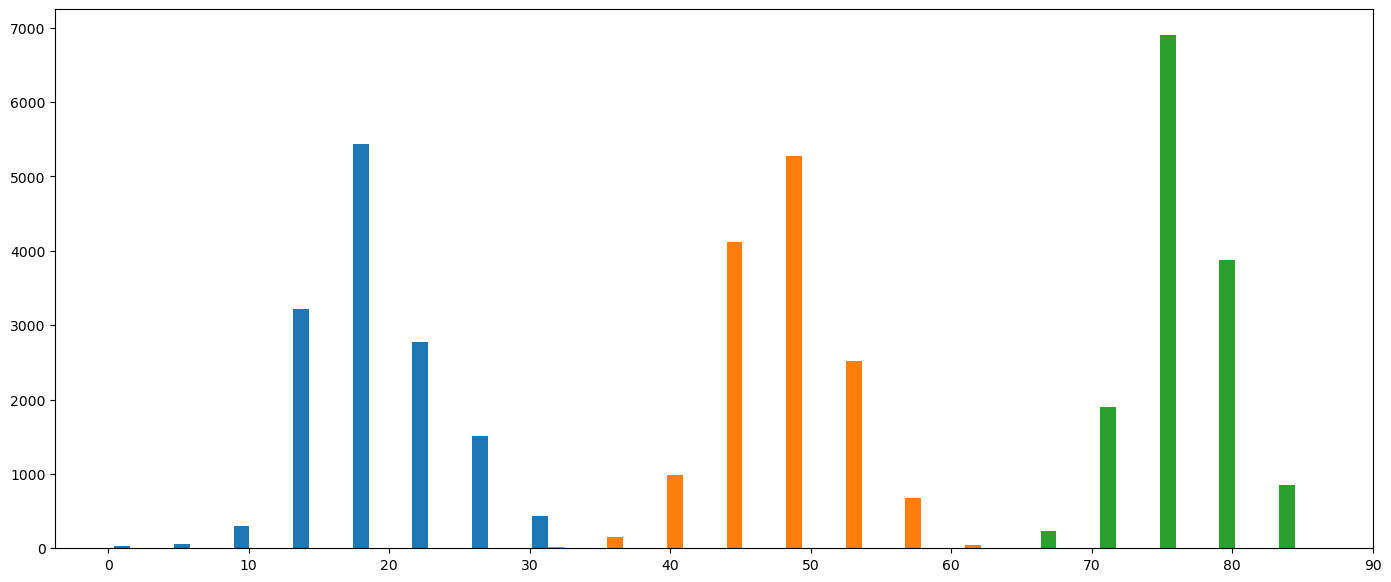

In [48]:
plt.figure(figsize=(17,7))
plt.hist([df_train_clean["rougher.input"],df_train_clean["rougher.output"],df_train_clean["final.output"]],bins=20)
plt.xticks(np.arange(0,91,10))
plt.show()

Despues de eliminar los datos atipicos podemos ver que los datos se han vuelto parejos y se ubican cercanos a la media y mediana en cada columna.

## Modelos predictivos



In [49]:
rs=RandomState(54321) #fijamos los valores para randomstate 

## Features y Targets

In [50]:
test_date=df_test["date"]#obtenemos las fechas
test_targets=df_full[df_full["date"].isin(test_date)]#filtramos df_full con las fechas del test
test_targets=test_targets.loc[:,("rougher.output.recovery","final.output.recovery")]#Extraemos las columnas que necesitamos predecir
print(test_targets.shape)#Comprobamos que contamos con todas las filas y columnas necesarias


(5856, 2)


Ya tenemos los targets de testeo. Falta crear los targets y features para el entrenamiento

#### test features

In [51]:
test_features = df_test.loc[:,['primary_cleaner.input.sulfate','primary_cleaner.input.depressant', 'primary_cleaner.input.feed_size','primary_cleaner.input.xanthate', 'rougher.input.feed_ag','rougher.input.feed_pb', 'rougher.input.feed_rate','rougher.input.feed_size', 'rougher.input.feed_sol','rougher.input.feed_au']]

test_features.shape

(5856, 10)

#### train features

In [52]:

train_features = df_train_clean.loc[:,['primary_cleaner.input.sulfate','primary_cleaner.input.depressant', 'primary_cleaner.input.feed_size','primary_cleaner.input.xanthate', 'rougher.input.feed_ag','rougher.input.feed_pb', 'rougher.input.feed_rate','rougher.input.feed_size', 'rougher.input.feed_sol','rougher.input.feed_au']]

train_features.shape

(13761, 10)

#### train targets

In [53]:

train_targets=df_train_clean.loc[:,["rougher.output.recovery","final.output.recovery"]]
train_targets.shape

(13761, 2)

## Función SMAPE

In [ ]:
# Con la siguiente función se pretende calcular el SMAPE final
def final_smape(target,prediction):
    def smape(target,prediction):
        smape=np.mean((np.abs(target-prediction)/((np.abs(target)+np.abs(prediction))/2)))*100
        return smape
    #Calculamos smpae fial para rougher[0] y final[1]
    smape_rougher=smape(target.iloc[:,0],prediction[:,0])
    smape_final=smape(target.iloc[:,1],prediction[:,1])
    final_smape=(0.25*smape_rougher)+(0.75*smape_final)
    return final_smape
sMAPE_score = make_scorer(final_smape, greater_is_better = False)

In [55]:
X_train, y_train, X_test, y_test = train_test_split(train_features, train_targets, test_size=0.25, random_state=rs)

## DecisionTreeRegressor

In [56]:
score = 0
for roots in range(3,9):
    for leafs in range(3,9):
        tree = DecisionTreeRegressor(random_state=rs, max_depth=roots, min_samples_leaf=leafs).fit(X_train, X_test)
        sco = tree.score(y_train, y_test)
        if sco>score:
            score = sco
            best_root = roots
            best_leaf = leafs

best_tree = DecisionTreeRegressor(random_state=rs, max_depth=best_root, min_samples_leaf=best_leaf)
np.abs(cross_val_score(best_tree, train_features, train_targets, scoring=sMAPE_score))

array([11.32697427,  8.76932756,  8.89306039,  7.87155881, 10.39857971])

In [57]:
np.abs(cross_val_score(best_tree, train_features, train_targets, scoring=sMAPE_score)).mean()

9.451900148194465

## RandomForestRegressor

In [58]:
score = 0
for roots in range(3,9):
    for leafs in range(3,9):
        forest = RandomForestRegressor(random_state=rs, max_depth=roots, min_samples_leaf=leafs).fit(X_train, X_test)
        sco = tree.score(y_train, y_test)
        if sco>score:
            score = sco
            best_root = roots
            best_leaf = leafs

best_forest = DecisionTreeRegressor(random_state=rs, max_depth=best_root, min_samples_leaf=best_leaf)
np.abs(cross_val_score(best_forest, train_features, train_targets, scoring=sMAPE_score))

array([10.01287142,  7.73263837,  7.97045881,  7.69864855, 11.49796759])

In [59]:
np.abs(cross_val_score(best_forest, train_features, train_targets, scoring=sMAPE_score)).mean()

8.982516949831824

## LinearRegresssion

In [60]:
reg=LinearRegression()
np.abs(cross_val_score(reg,train_features,train_targets,scoring=sMAPE_score))

array([ 9.86377847,  7.05578171,  7.38700451,  8.41603018, 12.37588008])

In [61]:

np.abs(cross_val_score(reg, train_features, train_targets, scoring=sMAPE_score)).mean()

9.019694990501065

RandomForestRegressor es nuestra mejor opción. Ahora procedo a realizar una prueba contra un modelo Dummy y luego probaremos nuestro mejor modelo con el set de testeo.

## DummyRegressor

In [62]:
dummy_regr = DummyRegressor(strategy="mean")
np.abs(cross_val_score(dummy_regr, train_features, train_targets, scoring=sMAPE_score))

array([10.63643083,  8.72825256,  7.99677908, 10.31687556, 11.06002411])

In [63]:
np.abs(cross_val_score(dummy_regr, train_features, train_targets, scoring=sMAPE_score)).mean()

9.74767242732824

El modelo Dummy regresa valores más altos de errores porcentuales.Teniendo casi unpunto completo por arriba de RandomForestRegressor.

## Testeo

In [64]:
# Modelo de bosque aleatorio
best_forest.fit(train_features, train_targets)
pred = best_forest.predict(test_features)
final_smape(test_targets, pred)

10.978968670820038

El valor aumento, ahora comprobare si los resultados del modelo realmente son los mejores posibles.

In [ ]:
# Modelo de arbol de decisión
best_tree.fit(train_features, train_targets)
pred = best_tree.predict(test_features)
final_smape(test_targets, pred)

13.157326818192047

In [66]:
# Modelo de regresión linear
reg.fit(train_features, train_targets)
pred = reg.predict(test_features)
final_smape(test_targets, pred)

12.375597888948441

In [67]:
# Modelo dummy
dummy_regr.fit(train_features, train_targets)
pred = dummy_regr.predict(test_features)
final_smape(test_targets, pred)

12.38511457064152

RandomForestRegressor es el mejor modelo.

## Conclusión general

Luego de analizar la información, comparar las cantidades de metales en las etapas de purificación, las distribuciones de alimentación a estas etapas y las concentraciones totale en las distintas etapas del proceso, ya podemos contar con datos confiables y dentro de rangos normales. Comenzamos probando 3 modelos predictivos basandonos en la métrica sMAPE. De estos obtuvimos los mejores resultados con RandomForestRegressor. Con este modelo logramos obtener el menor error en nuestras predicciones. Alcanzando poco menos de 11 en el momento de testearlo.

Se espera que con este modelo podamos predecir los valores de oro producidos por este proceso de purificación. Por lo menos para muestras que se encuentren dentro de rangos normales como los seleccionados en la sección de DecisionTreeRegressor.